
## **Stage 6	인사이트 도출 - 연체 위험군 탐색 및 패턴 분석**

<img src='http://drive.google.com/uc?export=view&id=1MAB-YSVPW8c7F0zBxVyZE3jXB0k-jq6z' /><br>

## **INTRO**
지난 스테이지 **Stage 5. 모델링의 활용 - <font color="blue">HOW</font> 어떻게 연체 정도를 예측할까?** 에서 통계, 머신러닝, 딥러닝 모델의 특징을 파악하고, 하이퍼파라미터 튜닝으로 최적 모델을 얻었습니다 😀     

예측 모델로 **직접 신용카드 연체 정도를 예측**하는데 사용할 수 있을뿐만 아니라,     
**신용카드 연체 정도에 대한 다양한 인사이트를 도출**할 수 있습니다 😎    

마지막 스테이지는 지금까지 학습한 모델을 분석하고,    
고객 세분화를 통한 연체 위험군 탐색 및 신용카드 발급 후 초기 연체 패턴 분석과 관련하여 인사이트를 도출할 예정입니다.

먼저, 데이터셋을 준비해볼까요?

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive') # 구글 드라이브를 사용하는 경우

PATH = "/content/drive/MyDrive/데이크루6기_보초석분/data/"

train = pd.read_csv(PATH+'train.csv') # pd.read_csv(PATH) -> PATH에 로컬 저장 경로 입력 ex) C:/home/data/train.csv
test = pd.read_csv(PATH+'test.csv')
submission = pd.read_csv(PATH+'sample_submission.csv')

Mounted at /content/drive


In [2]:
# 데이터 전처리 전체 코드
## 1. 결측치 처리 및 비정상 변수 삭제
train.fillna('NaN', inplace=True)
test.fillna('NaN', inplace=True)
train = train.drop('FLAG_MOBIL', axis=1)
test = test.drop('FLAG_MOBIL', axis=1)

## 2. 라벨 & 원핫 인코딩
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder()

columns_to_label = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']
columns_to_onehot = ['gender', 'car', 'reality']

for column in columns_to_label:
    train[column] = label_encoder.fit_transform(train[column])
    print(label_encoder.classes_)
    test[column] = label_encoder.transform(test[column])

for column in columns_to_onehot:
    train[column] = onehot_encoder.fit_transform(train[column].values.reshape(-1, 1)).toarray()
    print(onehot_encoder.categories_)
    test[column] = onehot_encoder.transform(test[column].values.reshape(-1, 1)).toarray()


## 3. 파생변수 생성
train['Income_Per_Family_Member'] = train['income_total'] / train['family_size']
train['Child_to_Family_Ratio'] = train['child_num'] / train['family_size']
train['Is_Working'] = train['DAYS_EMPLOYED'].apply(lambda x: 0 if x >= 0 else 1)

test['Income_Per_Family_Member'] = test['income_total'] / test['family_size']
test['Child_to_Family_Ratio'] = test['child_num'] / test['family_size']
test['Is_Working'] = test['DAYS_EMPLOYED'].apply(lambda x: 0 if x >= 0 else 1)



## 4. 이상치 처리
import numpy as np

columns_to_process = [column for column in train.columns if column != 'credit' and train[column].dtype in ['int64', 'float64']]

for column in columns_to_process:
    Q1 = train[column].quantile(0.25)
    Q3 = train[column].quantile(0.75)
    IQR = Q3 - Q1
    min_value = Q1 - 1.5 * IQR
    max_value = Q3 + 1.5 * IQR
    train[column] = np.where(train[column] < min_value, min_value, train[column])
    train[column] = np.where(train[column] > max_value, max_value, train[column])


## 4. 데이터 스케일링
continuous_features = ['child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'family_size', 'begin_month', 'Income_Per_Family_Member', 'Child_to_Family_Ratio']

selected_scalers = {}

for feature in continuous_features:
    if train[feature].skew() > 1:
        selected_scalers[feature] = 'RobustScaler'
    elif train[feature].min() >= 0:
        selected_scalers[feature] = 'MinMaxScaler'
    else:  # 특성이 정규 분포일 경우
        selected_scalers[feature] = 'StandardScaler'

print(selected_scalers)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

scaled_features = {}
for feature, scaler_name in selected_scalers.items():
    scaler = scalers[scaler_name]
    train[feature] = scaler.fit_transform(train[[feature]])
    test[feature] = scaler.transform(test[[feature]])

print(selected_scalers, scaled_features)

['Commercial associate' 'Pensioner' 'State servant' 'Student' 'Working']
['Academic degree' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Secondary / secondary special']
['Civil marriage' 'Married' 'Separated' 'Single / not married' 'Widow']
['Co-op apartment' 'House / apartment' 'Municipal apartment'
 'Office apartment' 'Rented apartment' 'With parents']
['Accountants' 'Cleaning staff' 'Cooking staff' 'Core staff' 'Drivers'
 'HR staff' 'High skill tech staff' 'IT staff' 'Laborers'
 'Low-skill Laborers' 'Managers' 'Medicine staff' 'NaN'
 'Private service staff' 'Realty agents' 'Sales staff' 'Secretaries'
 'Security staff' 'Waiters/barmen staff']
[array(['F', 'M'], dtype=object)]
[array(['N', 'Y'], dtype=object)]
[array(['N', 'Y'], dtype=object)]
{'child_num': 'RobustScaler', 'income_total': 'MinMaxScaler', 'DAYS_BIRTH': 'StandardScaler', 'DAYS_EMPLOYED': 'StandardScaler', 'family_size': 'MinMaxScaler', 'begin_month': 'StandardScaler', 'Income_Per_Family_Member': 'MinMaxSca

In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = train.columns
vif_data["VIF"] = [variance_inflation_factor(train.values, i) for i in range(train.shape[1])]

train = train.drop(vif_data[vif_data["VIF"] > 10]['Variable'].tolist(), axis=1)
test= test.drop(vif_data[vif_data["VIF"] > 10]['Variable'].tolist(), axis=1)

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [5]:
from sklearn.model_selection import train_test_split

X = train.drop(['index', 'credit'], axis=1)
y = train[['credit']]

# 1. train_test_split()을 이용하여 데이터를 분리합니다. (단, test_size는 0.2, random_state는 42로 설정합니다)
train_X, test_X, train_Y, test_Y = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)

print(train_X.shape, test_X.shape, train_Y.shape, test_Y.shape)

(21165, 16) (5292, 16) (21165, 1) (5292, 1)


### **1. 연체정도 결정에 영향을 미치는 변수 조사**
이전에 학습했던 모델을 사용하여 feature importance를 분석해 보겠습니다. 모델을 불러와서 변수 중요도를 시각화해봅시다!

In [6]:
# 머신러닝 모델 학습 관련 라이브러리
from lightgbm import LGBMClassifier
from lightgbm import early_stopping

# log_loss 성능평가 계산을 위한 라이브러리
from sklearn.metrics import log_loss

In [7]:
import joblib

load_model = joblib.load('/content/drive/MyDrive/대외활동/데이크루6기_보초석분/lgb_final_model.pkl')

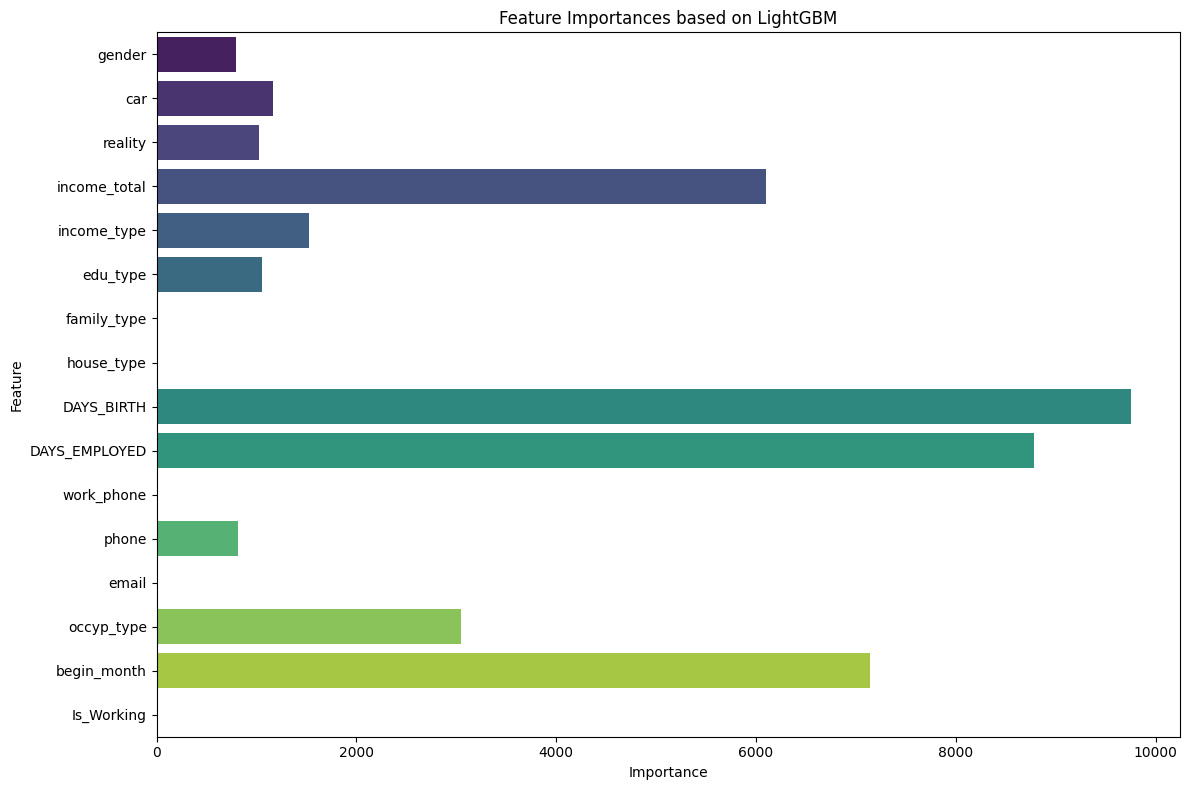

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(data=pd.concat([pd.DataFrame(train_X.columns, columns=['Feature']), pd.DataFrame(load_model.feature_importances_, columns=['Importance'])], axis=1), x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importances based on LightGBM')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

LightGBM 모델을 기반으로 한 변수 중요도는 다음과 같습니다.

- DAYS_BIRTH: 생일로부터의 일수 (가장 중요한 변수로 판단됨)
- DAYS_EMPLOYED: 고용 시작일로부터의 일수
- begin_month: 카드 발급 월로부터의 개월 수
- income_total: 총 수입

### **2. 고객 세분화를 통한 연체 위험군 탐색**

- 연체 정도에 영향을 미치는 변수를 바탕으로 고객을 세분화하고, 특정 세그먼트에서 연체 위험이 높은 고객군을 파악합니다. 이를 통해 연체 위험이 높은 고객군에 대한 관리 전략을 세울 수 있습니다.

다음으로, 연체 위험군 탐색을 위한 고객 세분화를 진행하겠습니다. 연체 정도에 영향을 미치는 주요 변수를 바탕으로 클러스터링을 진행하여 고객을 세분화하고, 특정 세그먼트에서 연체 위험이 높은 고객군을 파악해 보겠습니다.

클러스터의 수를 4로 설정하여 KMeans 클러스터링을 진행하겠습니다. 이후 각 클러스터의 특성을 분석하여 연체 위험도가 높은 고객군을 확인해보겠습니다.


In [25]:
train = pd.read_csv(PATH+'train.csv')

In [38]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# 중요한 특성들을 특성 중요도를 기반으로 선택
selected_features = ['begin_month', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'income_total']
X_cluster = train[selected_features]

# 데이터 표준화
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

scores = []
cluster_range = range(2, 11)
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_cluster)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(X_cluster, labels)
    scores.append(silhouette_avg)

# KMeans 클러스터링을 사용하여 5개의 클러스터 생성
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
train['cluster'] = kmeans.fit_predict(X_cluster)

# 각 클러스터에서 중요한 특성들과 타겟의 평균값 분석
cluster_summary = train.groupby('cluster')[selected_features + ['credit']].mean()
cluster_summary

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

,begin_month,DAYS_BIRTH,DAYS_EMPLOYED,income_total,credit
cluster,,,,,
0,25.389578,-16832.940213,-1851.592117,94809.316873,1.518158
1,25.856734,-16303.063037,-2791.340974,680426.638968,1.558739
2,26.506742,-15685.061046,-2379.595940,230600.416358,1.532968
3,26.213389,-15631.028334,-2170.787130,153963.388583,1.511365
4,26.668136,-15600.912203,-2601.425763,351221.033898,1.514237


5개의 클러스터링 결과는 다음과 같습니다.

1. **클러스터 0**
- 평균 카드 발급 후 경과 월: 약 25.4개월
- 평균 나이: 약 46살
- 평균 고용된 기간: 약 5.1년
- 평균 수입: 약 94,809.32
- 평균 신용도: 1.52

2. **클러스터 1**
- 평균 카드 발급 후 경과 월: 약 25.9개월
- 평균 나이: 약 45살
- 평균 고용된 기간: 약 7.7년
- 평균 수입: 약 680,426.64
- 평균 신용도: 1.56

3. **클러스터 2**
- 평균 카드 발급 후 경과 월: 약 26.5개월
- 평균 나이: 약 43살
- 평균 고용된 기간: 약 6.6년
- 평균 수입: 약 230,600.42
- 평균 신용도: 1.53

4. **클러스터 3**
- 평균 카드 발급 후 경과 월: 약 26.2개월
- 평균 나이: 약 43살
- 평균 고용된 기간: 약 6년
- 평균 수입: 약 153,963.39
- 평균 신용도: 1.51

5. **클러스터 4**
- 평균 카드 발급 후 경과 월: 약 26.7개월
- 평균 나이: 약 43살
- 평균 고용된 기간: 약 7.2년
- 평균 수입: 약 351,221.03
- 평균 신용도: 1.51

이 결과를 바탕으로, 클러스터마다 연체 위험도가 어떻게 다른지 파악할 수 있습니다. 클러스터 1에서 평균 신용도가 1.56으로 가장 높게 나타납니다.


### **3. 신용카드 발급 후 초기 연체 패턴 분석**

다음으로, 신용카드 발급 후 초기 연체 패턴을 분석하기 위해, 카드 발급 초기 (begin_month의 하위 30%)의 데이터를 추출하여 분석해보겠습니다.

In [34]:
train['begin_month'] = abs(train['begin_month'])
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x: 0 if x > 0 else x)

In [35]:
# 카드 발급 후 초기 기간의 데이터 필터링 (begin_month의 하위 30%)
initial_period_threshold = train['begin_month'].quantile(0.3)
initial_data = train[train['begin_month'] >= initial_period_threshold]

# 초기 기간 데이터에서 중요한 특성들과 타겟의 평균값 분석
initial_summary = initial_data[selected_features + ['credit']].mean()

initial_summary

begin_month          33.849443
DAYS_BIRTH       -16054.696658
DAYS_EMPLOYED     -2299.160584
income_total     189183.936844
credit                1.586844
dtype: float64

In [37]:
2299/365

6.298630136986302

카드 발급 초기 (하위 30% 범위)의 데이터 분석 결과는 다음과 같습니다:

1. **카드 발급 후 경과 월**: 평균 약 33개월
2. **평균 나이**: 약 43년
3. **평균 고용된 기간**: 약 6년
4. **평균 수입**: 약 189,183
5. **평균 신용도**: 1.58

카드 발급 초기에 연체가 발생하는 경우의 특징으로는, 평균적으로 중간 수준의 수입을 가진 43세 정도의 고객들이 주를 이루며, 신용도는 약 1.58로 나타납니다.

이 정보를 바탕으로, 카드 발급 초기에 연체 위험을 감소시키기 위한 전략을 세울 수 있습니다.

신용카드 사용자 연체 예측 프로젝트가 끝났습니다!    
재미있게 학습하셨을까요?    

<img src='http://drive.google.com/uc?export=view&id=1NbZ85U6Ea0utePGqwyXrE4iw_P3uD-kR' /><br>



데이터로 미래를 예측하는 것은 멋있고, 기대되는 일이라고 생각해요~ 😎    

데이터 분석의 세계로 오신 여러분을 진심으로 환영하며, 프로젝트를 마치겠습니다!    
스테이지 동안 고생 많으셨어요~ 👏
